In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from gs_quant.instrument import FXBinary, FXMultiCrossBinary, FXMultiCrossBinaryLeg
from gs_quant.markets import PricingContext
from gs_quant.risk import FXSpot
from gs_quant.session import GsSession

In [2]:
GsSession.use(client_id=None, client_secret=None, scopes=('run_analytics'))

In this notebook, we will screen for attractive dual binaries in FX to express a leveraged view on a potential vaccine led COVID recovery. This is an example of the GS Quant functionalities and it is not a recommendation of a trade in the instruments discussed, please follow up with your salesperson to discuss specific implementations

## 1 - Define a few functions and inputs

Let's start by defining a few functions and inputs to improve the readability of the notebook.

First, let's define a tenor and our targets for various FX crosses. In this example, we are leveraging GS GIR's work for analyzing FX price targets in the event of an approved EUA of a COVID vaccine by the end of the year ([source](https://marquee.gs.com/content/research/en/reports/2020/11/08/e8589bbb-cc23-4480-859a-000a8014bd1d.html)). However, the framework we build in this notebook could be deployed to your own targets on vaccine developments (or any other relevant themes).

In [3]:
# note that we are representing FX crosses as strings in mathematical notation (e.g. USD per GBP)
targets = {
    'USD/GBP': (1.34, 'call'),
    'USD/AUD': (0.75, 'call'),
    'USD/EUR': (1.20, 'call'),
    'CAD/USD': (1.28, 'put'),
    'JPY/USD': (104.1, 'call'),
    'KRW/USD': (1099, 'put'),
    'BRL/USD': (5.26, 'put'),
    'MXN/USD': (19.87, 'put')
}

tenor = '2m'
crosses = targets.keys()

Next, we'll define a few utility functions we'll use throughout the notebook.

In [4]:
def build_binary(tenor, cross, strike, opt_type, size=10e6, denominated='USD', buy_sell='Buy'):
    '''
    utility method to construct a FXBinaryBuilder
    '''
    return FXBinary(
        buy_sell=buy_sell,
        expiration_date=tenor,
        option_type=opt_type,
        notional_currency=denominated,
        pair=cross,
        strike_price=strike,
        premium=0, 
        notional_amount=size,
        payment_date=tenor
    )


def build_dual_binary(tenor, legs, size=10e6, denominated='USD', buy_sell='Buy'):
    '''
    utility method to construct an MCB builder
    '''
    built_legs = []
    for leg in legs:
        built_legs.append(FXMultiCrossBinaryLeg(
            strike_price=leg['strike'], pair=leg['cross'], option_type='Binary %s' % leg['opt_type']
        ))
    return FXMultiCrossBinary(buy_sell, tenor, legs=tuple(built_legs), premium=0, notional_amount=size,
                              notional_currency=denominated)



def plot_heatmap(data, cmap, ylabel, xlabel, title):
    '''
    Utility function to build a heatmap
    '''
    plt.subplots(figsize=(16, 10))

    vmax = data.max().max()
    vmin = data.min().min()

    ax = sns.heatmap(data, annot=True, vmin=vmin, vmax=vmax, fmt='.2f', cmap=cmap)
    ax.set(ylabel=ylabel, xlabel=xlabel, title=title)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    
def corr(mcb_price, p1, p2):
    '''
    compute the correlation implied by the dual binary price and individuals
    the sign is just the correlation between the payouts (so negative always indicates higher savings regardless of call/put combo)
    '''
    return (mcb_price - p1 * p2) / np.sqrt(p1 * (1 - p1) * p2 * (1 - p2))

## 2 - Vanilla Binaries

First, a quick example that shows how to compute  the percent price of a binary:

In [5]:
binary = build_binary('2m', 'JPY/USD', 104, 'Put')
binary.price() / 10e6

0.5046423444297603

Let's calculate the vanilla binary prices for each of our individual targets to get a sense of the probability the market is assigning to these targets.

In [6]:
vanilla_binaries = pd.DataFrame(index=crosses, columns=['spot_ref', 'target', 'price', 'price_future', 'risk_future'])

with PricingContext(is_batch=True):
    for cross, (strike, opt_type) in targets.items():
        binary = build_binary(tenor, cross, strike, opt_type)
        
        vanilla_binaries.loc[cross, 'price_future'] = binary.price()
        vanilla_binaries.loc[cross, 'risk_future'] = binary.calc(FXSpot)       
        vanilla_binaries.loc[cross, 'target'] = strike

In [7]:
# once all results are computed summarize relevant details
for cross in crosses:
    vanilla_binaries.loc[cross, 'price'] = vanilla_binaries.loc[cross, 'price_future'].result() / 10e6
    vanilla_binaries.loc[cross, 'spot_ref'] = vanilla_binaries.loc[cross, 'risk_future'].result()
        
vanilla_binaries[['spot_ref', 'target', 'price']].sort_values('price')

,spot_ref,target,price
CAD/USD,1.30665,1.28,0.215593
USD/AUD,0.73208,0.75,0.255526
USD/EUR,1.1867,1.2,0.318962
MXN/USD,20.2446,19.87,0.36556
KRW/USD,1105.25,1099,0.426555
USD/GBP,1.3301,1.34,0.456705
BRL/USD,5.3062,5.26,0.466285
JPY/USD,103.745,104.1,0.478362


## 3 - Dual Binaries

Now calculate the price for ever combination of dual binaries struck at the targets defined above. The top row displays the cheapest dual binary by price, with the right column indicating the savings to the cheapest digi. Darker colors indicate potentially higher savings and therefore potentially more attractive dual digis.

Please note that the payout of dual binaries is not guaranteed and is dependent on the level of FX spot in both crosses at the time of expiry.

In [8]:
dual_binary_dict = []
with PricingContext(is_batch=True):
    # iterate over all 2-cross combinations
    for idx, (cross1, cross2) in enumerate(itertools.combinations(crosses, 2)):
        # build the dual binary
        legs = [
            {'cross': cross1, 'strike': targets[cross1][0], 'opt_type': targets[cross1][1]},
            {'cross': cross2, 'strike': targets[cross2][0], 'opt_type': targets[cross2][1]}
        ]
        mcb = build_dual_binary(tenor, legs)

        dual_binary_dict.append({
            'cross1': cross1,
            'cross2': cross2,            
            'price_future': mcb.price(),
        })       

In [9]:
for row in dual_binary_dict:
    row['price'] = row['price_future'].result() / 10e6
    
    # individual prices
    row['individual_1'] = vanilla_binaries.loc[row['cross1'], 'price']
    row['individual_2'] = vanilla_binaries.loc[row['cross2'], 'price']
    
    row['corr'] = corr(row['price'], row['individual_1'], row['individual_2'])
    # define savings as the % savings from the cheapest individual binary
    row['savings'] = 1 - row['price'] / min(row['individual_1'], row['individual_2'])
    
    
dual_binaries = pd.DataFrame(dual_binary_dict)[['cross1', 'cross2', 'price', 'savings', 'corr', 'individual_1', 'individual_2']]

Format the results, showing only the 10 dual binaries with the absolute cheapest mid prices

In [10]:
display_table = dual_binaries.sort_values('price').head(10)

display_table['price'] = pd.Series(['{0:.1f}%'.format(val * 100) for val in display_table['price']], index=display_table.index)
display_table['savings'] = pd.Series([int(val * 100) for val in display_table['savings']], index=display_table.index)

display_table['corr'] = pd.Series(['{0:.1f}%'.format(val * 100) for val in display_table['corr']], index=display_table.index)

display_table['individual_1'] = pd.Series(['{0:.1f}%'.format(val * 100) for val in display_table['individual_1']], index=display_table.index)
display_table['individual_2'] = pd.Series(['{0:.1f}%'.format(val * 100) for val in display_table['individual_2']], index=display_table.index)

display_table.style.background_gradient(subset=['savings'])

,cross1,cross2,price,savings,corr,individual_1,individual_2
18,CAD/USD,JPY/USD,7.3%,65,-14.5%,21.6%,47.8%
9,USD/AUD,JPY/USD,7.4%,70,-21.9%,25.6%,47.8%
14,USD/EUR,JPY/USD,8.7%,72,-28.1%,31.9%,47.8%
21,CAD/USD,MXN/USD,12.4%,42,22.9%,21.6%,36.6%
13,USD/EUR,CAD/USD,14.1%,34,37.7%,31.9%,21.6%
8,USD/AUD,CAD/USD,14.5%,32,50.4%,25.6%,21.6%
24,JPY/USD,MXN/USD,15.1%,58,-10.1%,47.8%,36.6%
2,USD/GBP,CAD/USD,15.8%,26,29.2%,45.7%,21.6%
3,USD/GBP,JPY/USD,15.9%,65,-23.8%,45.7%,47.8%
19,CAD/USD,KRW/USD,16.4%,23,35.5%,21.6%,42.7%


## 4 - Dual Binary Grids

We will now consider a wider range of strikes for the cheapest dual binary in
the table above. Let us consider strikes within a 3% range from the targets
defined above. The tables below show both the mid price and the implied correlation. Optimizing both of these outputs allows us to determine
our preferable strikes for the trade.

In [11]:
min_price_index = dual_binaries['price'].idxmin()
cross1 = dual_binaries.iloc[min_price_index]['cross1']
cross2 = dual_binaries.iloc[min_price_index]['cross2']

# % from target strikes to compute for the grid
strikes = [-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]

mcb_ppct_future = pd.DataFrame(index=strikes, columns=strikes)
indiv_ppct_future = pd.DataFrame(index=strikes, columns=[cross1, cross2])

with PricingContext(is_batch=True):
    # loop over all dual binary combinations
    for (i, j) in itertools.product(strikes, strikes):
        strike1 = targets[cross1][0] * (1 + i / 100)
        strike2 = targets[cross2][0] * (1 + j / 100)

        # build the dual binary
        legs = [
            {'cross': cross1, 'strike': strike1, 'opt_type': targets[cross1][1]},
            {'cross': cross2, 'strike': strike2, 'opt_type': targets[cross2][1]}
        ]
        mcb = build_dual_binary(tenor, legs)
        mcb_ppct_future.loc[i, j] = mcb.price()

    # loop over all indvidual binary combinations for both crosses
    # we'll use these to compute savings later as well
    for cross in [cross1, cross2]:
        for i in strikes:
            strike = targets[cross][0] * (1 + i / 100)
            binary = build_binary(tenor, cross, strike, targets[cross][1])
            indiv_ppct_future.loc[i, cross] = binary.price()

In [12]:
price_matrix = pd.DataFrame(index=strikes, columns=strikes, dtype='float64')
savings_matrix = pd.DataFrame(index=strikes, columns=strikes, dtype='float64')
corr_matrix = pd.DataFrame(index=strikes, columns=strikes, dtype='float64')

for (i, j) in itertools.product(strikes, strikes):
    # price pct of the mcb
    price_pct = mcb_ppct_future.loc[i, j].result() / 10e6
    price_matrix.loc[i, j] = price_pct * 100

    # calc savings    
    p_1 = indiv_ppct_future.loc[i, cross1].result() / 10e6
    p_2 = indiv_ppct_future.loc[j, cross2].result() / 10e6
    savings_matrix.loc[i, j] = 1 - (price_pct / min(p_1, p_2))
    
    # calc correlation
    corr_matrix.loc[i, j] = 100 * corr(price_pct, p_1, p_2)

Quickly sanity check the percent prices of the individual binaries at the different strike combinations:

In [13]:
round(indiv_ppct_future.applymap(lambda x: x.result() / 10e6) * 100, 1)

,CAD/USD,JPY/USD
-3.0,3.4,85.0
-2.5,4.8,81.4
-2.0,6.6,77.0
-1.5,9.1,71.3
-1.0,12.3,64.5
-0.5,16.4,56.5
0.0,21.6,47.8
0.5,27.7,39.1
1.0,34.8,30.9
1.5,42.6,23.6


First, let's plot the mid price of the dual binary for all of the strike combinations:

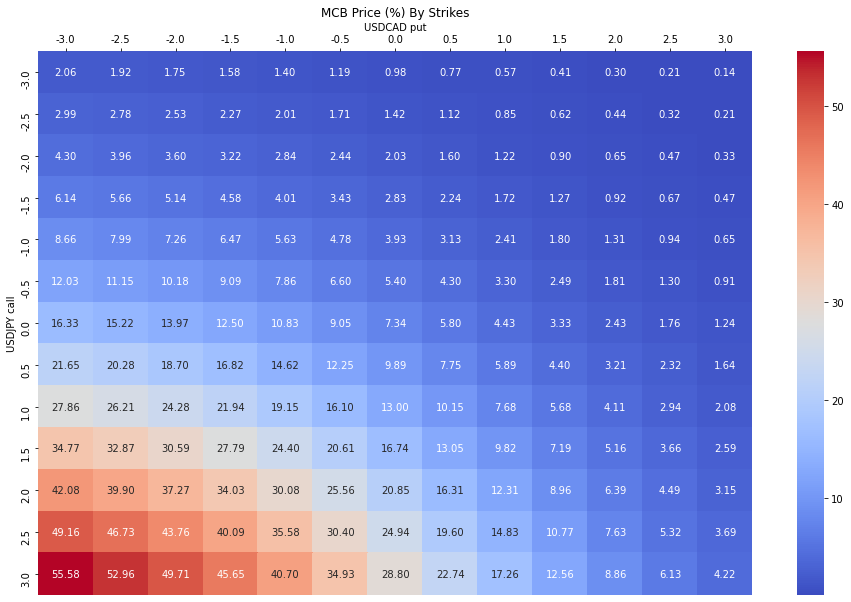

In [14]:
plot_heatmap(price_matrix, "coolwarm", cross2 + " " + targets[cross2][1],
             cross1 + " " + targets[cross1][1], "MCB Price (%) By Strikes")

Then, let's plot the savings vs. the cheapest inividual binary for all of the combinations on the grid. Negative numbers indicate correlations that provide more savings.

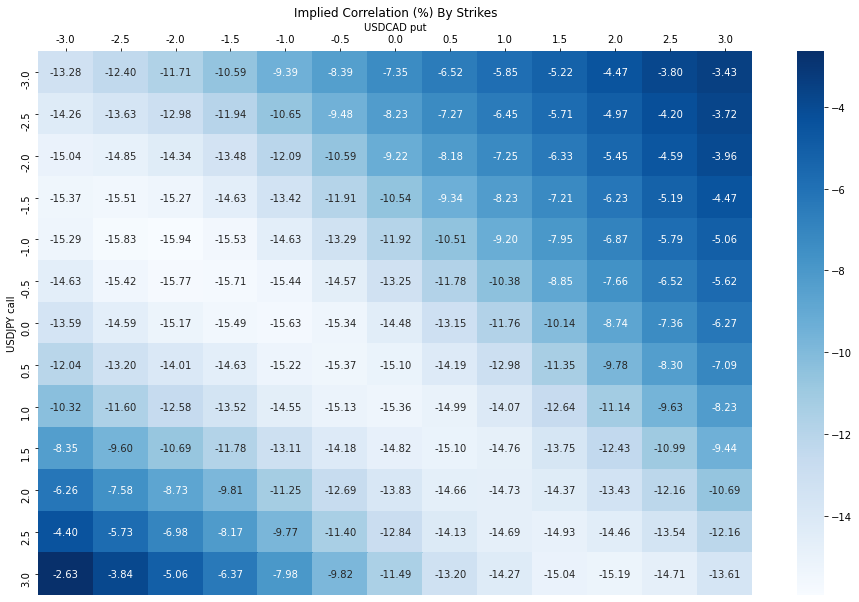

In [15]:
plot_heatmap(savings_matrix, "Blues", cross2 + " " + targets[cross2][1],
             cross1 + " " + targets[cross1][1], "Savings (%) By Strikes" )

## Appendix - Dual Binary Carry

In [16]:
with PricingContext(is_batch=True):
    for row in dual_binary_dict:
        # build the dual binary
        legs = [
            {'cross': row['cross1'], 'strike': targets[row['cross1']][0], 'opt_type': targets[row['cross1']][1]},
            {'cross': row['cross2'], 'strike': targets[row['cross2']][0], 'opt_type': targets[row['cross2']][1]}
        ]
        mcb = build_dual_binary('1m', legs)  # simple static carry, just reduce tenor to 1m

        row['price_fwd_future'] = mcb.price()

In [17]:
for row in dual_binary_dict:
    row['price_fwd'] = row['price_fwd_future'].result() / 10e6
    row['static_carry_1m'] = row['price_fwd'] - row['price']

carry_table = pd.DataFrame(dual_binary_dict).sort_values('static_carry_1m', ascending=False)
carry_table.head(10)[['cross1', 'cross2', 'price', 'savings', 'static_carry_1m']]

,cross1,cross2,price,savings,static_carry_1m
23,JPY/USD,BRL/USD,0.201774,0.567274,-0.015183
25,KRW/USD,BRL/USD,0.229853,0.461141,-0.017895
24,JPY/USD,MXN/USD,0.150649,0.587894,-0.021028
5,USD/GBP,BRL/USD,0.260522,0.429560,-0.022684
4,USD/GBP,KRW/USD,0.250200,0.413440,-0.025069
27,BRL/USD,MXN/USD,0.252088,0.310407,-0.025489
14,USD/EUR,JPY/USD,0.087249,0.726459,-0.027515
3,USD/GBP,JPY/USD,0.159157,0.651511,-0.027681
22,JPY/USD,KRW/USD,0.172747,0.595019,-0.028986
9,USD/AUD,JPY/USD,0.074424,0.708740,-0.030358


### Disclaimers

Indicative Terms/Pricing Levels: This material may contain indicative terms only, including but not limited to pricing levels. There is no representation that any transaction can or could have been effected at such terms or prices. Proposed terms and conditions are for discussion purposes only. Finalized terms and conditions are subject to further discussion and negotiation.
www.goldmansachs.com/disclaimer/sales-and-trading-invest-rec-disclosures.html If you are not accessing this material via Marquee ContentStream, a list of the author's investment recommendations disseminated during the preceding 12 months and the proportion of the author's recommendations that are 'buy', 'hold', 'sell' or other over the previous 12 months is available by logging into Marquee ContentStream using the link below. Alternatively, if you do not have access to Marquee ContentStream, please contact your usual GS representative who will be able to provide this information to you.
Backtesting, Simulated Results, Sensitivity/Scenario Analysis or Spreadsheet Calculator or Model: There may be data presented herein that is solely for illustrative purposes and which may include among other things back testing, simulated results and scenario analyses. The information is based upon certain factors, assumptions and historical information that Goldman Sachs may in its discretion have considered appropriate, however, Goldman Sachs provides no assurance or guarantee that this product will operate or would have operated in the past in a manner consistent with these assumptions. In the event any of the assumptions used do not prove to be true, results are likely to vary materially from the examples shown herein. Additionally, the results may not reflect material economic and market factors, such as liquidity, transaction costs and other expenses which could reduce potential return.
OTC Derivatives Risk Disclosures: 
Terms of the Transaction: To understand clearly the terms and conditions of any OTC derivative transaction you may enter into, you should carefully review the Master Agreement, including any related schedules, credit support documents, addenda and exhibits. You should not enter into OTC derivative transactions unless you understand the terms of the transaction you are entering into as well as the nature and extent of your risk exposure. You should also be satisfied that the OTC derivative transaction is appropriate for you in light of your circumstances and financial condition. You may be requested to post margin or collateral to support written OTC derivatives at levels consistent with the internal policies of Goldman Sachs. 

Liquidity Risk: There is no public market for OTC derivative transactions and, therefore, it may be difficult or impossible to liquidate an existing position on favorable terms. Transfer Restrictions: OTC derivative transactions entered into with one or more affiliates of The Goldman Sachs Group, Inc. (Goldman Sachs) cannot be assigned or otherwise transferred without its prior written consent and, therefore, it may be impossible for you to transfer any OTC derivative transaction to a third party. 

Conflict of Interests: Goldman Sachs may from time to time be an active participant on both sides of the market for the underlying securities, commodities, futures, options or any other derivative or instrument identical or related to those mentioned herein (together, "the Product"). Goldman Sachs at any time may have long or short positions in, or buy and sell Products (on a principal basis or otherwise) identical or related to those mentioned herein. Goldman Sachs hedging and trading activities may affect the value of the Products. 

Counterparty Credit Risk: Because Goldman Sachs, may be obligated to make substantial payments to you as a condition of an OTC derivative transaction, you must evaluate the credit risk of doing business with Goldman Sachs or its affiliates. 

Pricing and Valuation: The price of each OTC derivative transaction is individually negotiated between Goldman Sachs and each counterparty and Goldman Sachs does not represent or warrant that the prices for which it offers OTC derivative transactions are the best prices available, possibly making it difficult for you to establish what is a fair price for a particular OTC derivative transaction; The value or quoted price of the Product at any time, however, will reflect many factors and cannot be predicted. If Goldman Sachs makes a market in the offered Product, the price quoted by Goldman Sachs would reflect any changes in market conditions and other relevant factors, and the quoted price (and the value of the Product that Goldman Sachs will use for account statements or otherwise) could be higher or lower than the original price, and may be higher or lower than the value of the Product as determined by reference to pricing models used by Goldman Sachs. If at any time a third party dealer quotes a price to purchase the Product or otherwise values the Product, that price may be significantly different (higher or lower) than any price quoted by Goldman Sachs. Furthermore, if you sell the Product, you will likely be charged a commission for secondary market transactions, or the price will likely reflect a dealer discount. Goldman Sachs may conduct market making activities in the Product. To the extent Goldman Sachs makes a market, any price quoted for the OTC derivative transactions, Goldman Sachs may differ significantly from (i) their value determined by reference to Goldman Sachs pricing models and (ii) any price quoted by a third party. The market price of the OTC derivative transaction may be influenced by many unpredictable factors, including economic conditions, the creditworthiness of Goldman Sachs, the value of any underlyers, and certain actions taken by Goldman Sachs. 

Market Making, Investing and Lending: Goldman Sachs engages in market making, investing and lending businesses for its own account and the accounts of its affiliates in the same or similar instruments underlying OTC derivative transactions (including such trading as Goldman Sachs deems appropriate in its sole discretion to hedge its market risk in any OTC derivative transaction whether between Goldman Sachs and you or with third parties) and such trading may affect the value of an OTC derivative transaction. 

Early Termination Payments: The provisions of an OTC Derivative Transaction may allow for early termination and, in such cases, either you or Goldman Sachs may be required to make a potentially significant termination payment depending upon whether the OTC Derivative Transaction is in-the-money to Goldman Sachs or you at the time of termination. Indexes: Goldman Sachs does not warrant, and takes no responsibility for, the structure, method of computation or publication of any currency exchange rates, interest rates, indexes of such rates, or credit, equity or other indexes, unless Goldman Sachs specifically advises you otherwise.
Risk Disclosure Regarding futures, options, equity swaps, and other derivatives as well as non-investment-grade securities and ADRs: Please ensure that you have read and understood the current options, futures and security futures disclosure document before entering into any such transactions. Current United States listed options, futures and security futures disclosure documents are available from our sales representatives or at http://www.theocc.com/components/docs/riskstoc.pdf,  http://www.goldmansachs.com/disclosures/risk-disclosure-for-futures.pdf and https://www.nfa.futures.org/investors/investor-resources/files/security-futures-disclosure.pdf, respectively. Certain transactions - including those involving futures, options, equity swaps, and other derivatives as well as non-investment-grade securities - give rise to substantial risk and are not available to nor suitable for all investors. If you have any questions about whether you are eligible to enter into these transactions with Goldman Sachs, please contact your sales representative. Foreign-currency-denominated securities are subject to fluctuations in exchange rates that could have an adverse effect on the value or price of, or income derived from, the investment. In addition, investors in securities such as ADRs, the values of which are influenced by foreign currencies, effectively assume currency risk.
Options Risk Disclosures: Options may trade at a value other than that which may be inferred from the current levels of interest rates, dividends (if applicable) and the underlier due to other factors including, but not limited to, expectations of future levels of interest rates, future levels of dividends and the volatility of the underlier at any time prior to maturity. Note: Options involve risk and are not suitable for all investors. Please ensure that you have read and understood the current options disclosure document before entering into any standardized options transactions. United States listed options disclosure documents are available from our sales representatives or at http://theocc.com/publications/risks/riskstoc.pdf. A secondary market may not be available for all options. Transaction costs may be a significant factor in option strategies calling for multiple purchases and sales of options, such as spreads. When purchasing long options an investor may lose their entire investment and when selling uncovered options the risk is potentially unlimited. Supporting documentation for any comparisons, recommendations, statistics, technical data, or other similar information will be supplied upon request.
This material is for the private information of the recipient only. This material is not sponsored, endorsed, sold or promoted by any sponsor or provider of an index referred herein (each, an "Index Provider"). GS does not have any affiliation with or control over the Index Providers or any control over the computation, composition or dissemination of the indices. While GS will obtain information from publicly available sources it believes reliable, it will not independently verify this information. Accordingly, GS shall have no liability, contingent or otherwise, to the user or to third parties, for the quality, accuracy, timeliness, continued availability or completeness of the data nor for any special, indirect, incidental or consequential damages which may be incurred or experienced because of the use of the data made available herein, even if GS has been advised of the possibility of such damages.
iTraxx® is a registered trade mark of International Index Company Limited.
iTraxx® is a trade mark of International Index Company Limited and has been licensed for the use by Goldman Sachs Japan Co., Ltd. International Index Company Limited does not approve, endorse or recommend Goldman Sachs Japan Co., Ltd. or iTraxx® derivatives products.
iTraxx® derivatives products are derived from a source considered reliable, but neither International Index Company Limited nor any of its employees, suppliers, subcontractors and agents (together iTraxx Associates) guarantees the veracity, completeness or accuracy of iTraxx® derivatives products or other information furnished in connection with iTraxx® derivatives products. No representation, warranty or condition, express or implied, statutory or otherwise, as to condition, satisfactory quality, performance, or fitness for purpose are given or assumed by International Index Company Limited or any of the iTraxx Associates in respect of iTraxx® derivatives products or any data included in such iTraxx® derivatives products or the use by any person or entity of iTraxx® derivatives products or that data and all those representations, warranties and conditions are excluded save to the extent that such exclusion is prohibited by law.
None of International Index Company Limited nor any of the iTraxx Associates shall have any liability or responsibility to any person or entity for any loss, damages, costs, charges, expenses or other liabilities whether caused by the negligence of International Index Company Limited or any of the iTraxx Associates or otherwise, arising in connection with the use of iTraxx® derivatives products or the iTraxx® indices.
Standard & Poor's ® and S&P ® are registered trademarks of The McGraw-Hill Companies, Inc. and S&P GSCI™ is a trademark of The McGraw-Hill Companies, Inc. and have been licensed for use by the Issuer. This Product (the "Product") is not sponsored, endorsed, sold or promoted by S&P and S&P makes no representation, warranty or condition regarding the advisability of investing in the Product.
